In [1]:
# Install tsflex and seglearn
!pip install tsflex --no-index --find-links=file:///kaggle/input/time-series-tools
!pip install seglearn --no-index --find-links=file:///kaggle/input/time-series-tools

Looking in links: file:///kaggle/input/time-series-tools
Processing /kaggle/input/time-series-tools/tsflex-0.3.0-py3-none-any.whl
Looking in links: file:///kaggle/input/time-series-tools
Processing /kaggle/input/time-series-tools/seglearn-1.2.5-py3-none-any.whl


<p style="font-family: monospace; 
          font-weight: bold; 
          letter-spacing: 2px; 
          color: black; 
          font-size: 200%; 
          text-align: left;
          padding: 0px; 
          border-bottom: 4px solid #78D0AF" >Table of Contents</p>
          
          
* [Data loading and feature extraction](#section-one)
* [EDA on time for targets](#section-two)
* [Build the model and submit](#section-three)


# Data loading and feature extraction 

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn import *
import glob

p = '/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/'

train = glob.glob(p+'train/**/**')
test = glob.glob(p+'test/**/**')
subjects = pd.read_csv(p+'subjects.csv')
tasks = pd.read_csv(p+'tasks.csv')
sub = pd.read_csv(p+'sample_submission.csv')

tdcsfog_metadata=pd.read_csv('/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/tdcsfog_metadata.csv')
defog_metadata=pd.read_csv('/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/defog_metadata.csv')
tdcsfog_metadata['Module']='tdcsfog'
defog_metadata['Module']='defog'
# daily_metadata['Module']='daily'
metadata=pd.concat([tdcsfog_metadata,defog_metadata])
# metadata

In [4]:
tdcsfog_metadata

,Id,Subject,Visit,Test,Medication,Module
0,003f117e14,13abfd,3,2,on,tdcsfog
1,009ee11563,d81e3a,4,2,on,tdcsfog
2,011322847a,203e85,2,2,on,tdcsfog
3,01d0fe7266,203e85,2,1,off,tdcsfog
4,024418ba39,cecfb8,19,3,on,tdcsfog
...,...,...,...,...,...,...
828,feba449e1a,47860d,19,1,on,tdcsfog
829,ff4f844fd3,43fcae,2,3,on,tdcsfog
830,ff53514514,a2a051,2,3,on,tdcsfog
831,ff92d9244d,a9e866,20,2,on,tdcsfog


In [5]:
# https://www.kaggle.com/code/jazivxt/familiar-solvs
tasks['Duration'] = tasks['End'] - tasks['Begin']
tasks = pd.pivot_table(tasks, values=['Duration'], index=['Id'], columns=['Task'], aggfunc='sum', fill_value=0)
tasks.columns = [c[-1] for c in tasks.columns]
tasks = tasks.reset_index()


In [6]:
display(subjects.columns)

Index(['Subject', 'Visit', 'Age', 'Sex', 'YearsSinceDx', 'UPDRSIII_On',
       'UPDRSIII_Off', 'NFOGQ'],
      dtype='object')

In [7]:
tasks['t_kmeans'] = cluster.KMeans(n_clusters=10, random_state=3).fit_predict(tasks[tasks.columns[1:]])

subjects = subjects.fillna(0).groupby('Subject').median()
subjects = subjects.reset_index()
subjects['s_kmeans'] = cluster.KMeans(n_clusters=10, random_state=3).fit_predict(subjects[subjects.columns[1:]])
subjects=subjects.rename(columns={'Visit':'s_Visit','Age':'s_Age','YearsSinceDx':'s_YearsSinceDx','UPDRSIII_On':'s_UPDRSIII_On','UPDRSIII_Off':'s_UPDRSIII_Off','NFOGQ':'s_NFOGQ'})

display(tasks)
display(subjects)

,Id,4MW,4MW-C,Hotspot1,Hotspot1-C,Hotspot2,Hotspot2-C,MB1,MB10,MB11,...,MB9,Rest1,Rest2,TUG-C,TUG-DT,TUG-ST,Turning-C,Turning-DT,Turning-ST,t_kmeans
0,02ab235146,16.520,16.680,16.760,16.240,53.920,64.600,13.960,17.960,17.400,...,30.800,180.48,60.32,38.440,47.920,36.240,21.920,46.400,23.320,2
1,02ea782681,11.618,11.796,11.525,11.692,8.329,9.032,3.469,6.624,6.230,...,30.650,0.00,0.00,18.343,19.932,20.130,18.042,21.588,18.698,0
2,06414383cf,24.860,41.584,25.885,0.000,38.642,0.000,0.000,0.000,0.000,...,0.000,0.00,0.00,0.000,44.832,33.867,0.000,83.837,124.299,3
3,092b4c1819,13.664,0.000,15.409,0.000,34.834,0.000,0.000,0.000,0.000,...,0.000,0.00,0.00,0.000,30.166,23.347,0.000,45.025,39.351,7
4,0a900ed8a2,11.720,11.840,10.600,10.720,43.171,41.160,1.760,21.040,10.560,...,30.520,180.88,60.32,18.083,25.000,19.920,18.699,18.200,16.880,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,f3a921edee,16.722,0.000,16.383,0.000,76.200,0.000,0.000,0.000,0.000,...,0.000,0.00,0.00,0.000,29.043,29.820,0.000,136.840,76.960,3
133,f40e8c6ebe,12.867,0.000,27.906,0.000,152.333,0.000,0.000,0.000,0.000,...,0.000,0.00,0.00,0.000,36.805,28.232,0.000,98.579,69.889,3
134,f8ddbdd98d,23.787,0.000,32.556,0.000,38.557,0.000,6.347,10.356,10.655,...,33.289,0.00,0.00,0.000,44.132,54.993,0.000,100.433,72.152,3
135,f9efef91fb,16.351,17.552,16.155,15.166,67.059,51.715,0.000,0.000,0.000,...,0.000,0.00,0.00,23.483,23.541,22.137,36.898,38.632,30.831,7


,Subject,s_Visit,s_Age,s_YearsSinceDx,s_UPDRSIII_On,s_UPDRSIII_Off,s_NFOGQ,s_kmeans
0,04fcdb,1.0,63.0,3.0,30.0,0.0,0.0,3
1,05595e,1.0,56.0,8.0,28.0,0.0,0.0,3
2,0967b2,1.5,59.0,10.0,37.5,46.0,16.0,6
3,097078,0.0,70.0,10.0,27.0,50.0,20.0,0
4,0e0908,0.0,67.0,6.0,16.0,61.0,21.0,0
...,...,...,...,...,...,...,...,...
131,f80d3a,1.5,78.0,18.0,23.5,29.5,17.5,0
132,f90887,1.5,72.0,16.0,29.0,43.5,24.0,6
133,fc1e1b,1.0,82.0,11.0,38.0,42.0,21.0,2
134,fe5d84,1.5,72.0,14.0,22.5,39.0,16.0,0


In [8]:
complex_featlist=['Visit','Test','Medication','s_Visit','s_Age','s_YearsSinceDx','s_UPDRSIII_On','s_UPDRSIII_Off','s_NFOGQ','s_kmeans']
metadata_complex=metadata.merge(subjects,how='left',on='Subject').copy()
metadata_complex['Medication']=metadata_complex['Medication'].factorize()[0]

display(metadata_complex)

,Id,Subject,Visit,Test,Medication,Module,s_Visit,s_Age,s_YearsSinceDx,s_UPDRSIII_On,s_UPDRSIII_Off,s_NFOGQ,s_kmeans
0,003f117e14,13abfd,3,2.0,0,tdcsfog,0.0,68.0,9.0,17.0,15.0,15.0,8
1,009ee11563,d81e3a,4,2.0,0,tdcsfog,0.0,71.0,10.0,42.0,0.0,24.0,1
2,011322847a,203e85,2,2.0,0,tdcsfog,0.0,67.0,12.0,27.0,28.0,19.0,0
3,01d0fe7266,203e85,2,1.0,1,tdcsfog,0.0,67.0,12.0,27.0,28.0,19.0,0
4,024418ba39,cecfb8,19,3.0,0,tdcsfog,0.0,60.0,7.0,30.0,0.0,19.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
965,f3a921edee,ce8b0b,1,NaN,1,defog,1.5,65.0,7.0,50.0,59.5,24.5,2
966,f40e8c6ebe,d9529b,1,NaN,1,defog,1.0,28.0,4.0,54.0,50.0,25.0,9
967,f8ddbdd98d,fc1e1b,1,NaN,0,defog,1.0,82.0,11.0,38.0,42.0,21.0,2
968,f9efef91fb,fe5d84,2,NaN,1,defog,1.5,72.0,14.0,22.5,39.0,16.0,0


## Create a tsflex feature collection

In [9]:
from seglearn.feature_functions import base_features, emg_features

from tsflex.features import FeatureCollection, MultipleFeatureDescriptors
from tsflex.features.integrations import seglearn_feature_dict_wrapper


basic_feats = MultipleFeatureDescriptors(
    functions=seglearn_feature_dict_wrapper(base_features()),
    series_names=['AccV', 'AccML', 'AccAP'],
    windows=[5_000],
    strides=[5_000],
)

emg_feats = emg_features()
del emg_feats['simple square integral'] # is same as abs_energy (which is in base_features)

emg_feats = MultipleFeatureDescriptors(
    functions=seglearn_feature_dict_wrapper(emg_feats),
    series_names=['AccV', 'AccML', 'AccAP'],
    windows=[5_000],
    strides=[5_000],
)

fc = FeatureCollection([basic_feats, emg_feats])

## Extract the features (with Time_frac feature)

In [10]:

import pathlib
def reader(f):
    try:
        df = pd.read_csv(f, index_col="Time", usecols=['Time', 'AccV', 'AccML', 'AccAP', 'StartHesitation', 'Turn' , 'Walking'])
        
        df['Id'] = f.split('/')[-1].split('.')[0]
        df['Module'] = pathlib.Path(f).parts[-2]
        
        df['Time_frac']=(df.index/df.index.max()).values#currently the index of data is actually "Time"
        
        df = pd.merge(df, tasks[['Id','t_kmeans']], how='left', on='Id').fillna(-1)
#         df = pd.merge(df, subjects[['Id','s_kmeans']], how='left', on='Id').fillna(-1)
        df = pd.merge(df, metadata_complex[['Id','Subject']+['Visit','Test','Medication','s_kmeans']], how='left', on='Id').fillna(-1)
        df_feats = fc.calculate(df, return_df=True, include_final_window=True, approve_sparsity=True, window_idx="begin").astype(np.float32)
        df = df.merge(df_feats, how="left", left_index=True, right_index=True)
        df.fillna(method="ffill", inplace=True)
        return df
    except: pass
train = pd.concat([reader(f) for f in tqdm(train)]).fillna(0); print(train.shape)
cols = [c for c in train.columns if c not in ['Id','Subject','Module', 'Time', 'StartHesitation', 'Turn' , 'Walking', 'Valid', 'Task','Event']]
pcols = ['StartHesitation', 'Turn' , 'Walking']
scols = ['Id', 'StartHesitation', 'Turn' , 'Walking']

  0%|          | 0/970 [00:00<?, ?it/s]

(20588374, 72)


In [11]:
train=train.reset_index(drop=True)

# EDA: Looking at the distribution of Time for different target variable

1. add time feature: `df['Time_frac']=(df.Time/df.Time.max()).values`(finished in reader() function)
2. visualized the distribution of `Time_frac` for different target variable[`StartHesitation,Turn,Walking`]



<AxesSubplot:>

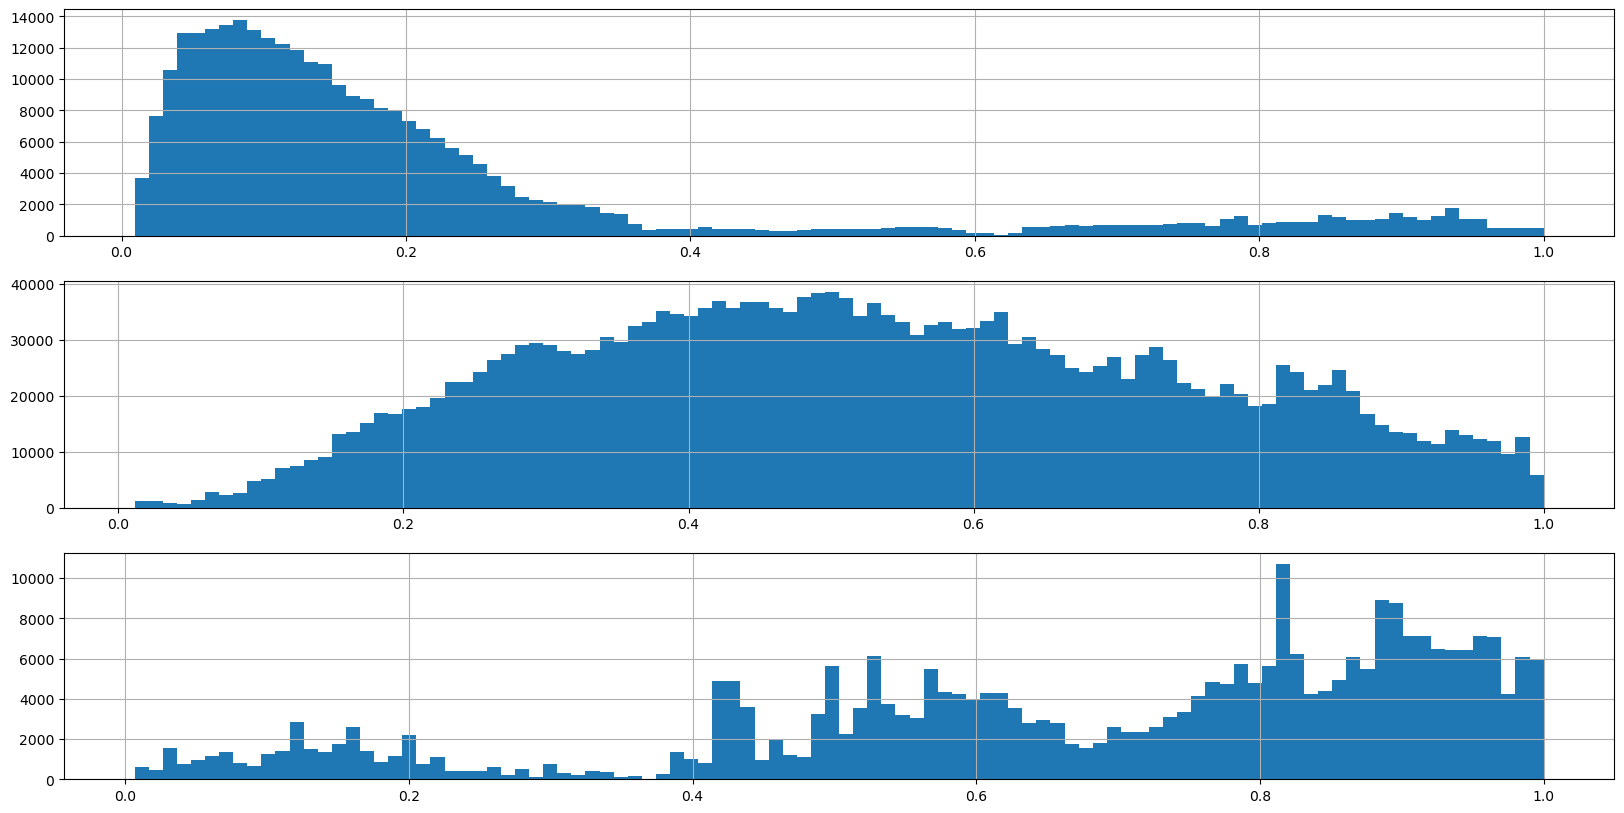

In [12]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots(3,1,figsize=(20,10))
train.loc[train['StartHesitation']==1,'Time_frac'].hist(ax=ax[0],bins=100)
train.loc[train['Turn']==1,'Time_frac'].hist(ax=ax[1],bins=100)
train.loc[train['Walking']==1,'Time_frac'].hist(ax=ax[2],bins=100)

##### The distribution betweeen `the 3 target[StartHesitation,Turn,Walking]` is totally different

##### review the Official definition
> The tDCS FOG (tdcsfog) dataset, comprising data series collected in the lab, as subjects `completed a FOG-provoking protocol`.

> The DeFOG (defog) dataset, comprising data series collected in the subject's home, as subjects `completed a FOG-provoking protocol`

##### EDA Discovery

- StartHesitation frequently occurs in the early stage, and rarely occurs in the late stage
- Turn frequently occurs in the middle stage
- Walking frequently occurs in the late stage

##### Assumption: In a `completed FOG-provoking protocol`, the order in which the event occur tends to follow the order `StartHesitation->Turn->Walking`

##### Application example: Add time fraction feature to model

# Build the model and submit

## Train the model

In [13]:
import lightgbm as lgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [14]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import uniform, randint
from sklearn.metrics import average_precision_score, make_scorer


#XGBoost hyper-parameter tuning
def hyperParameterTuning(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective': ['reg:squarederror']
    }

    xgb_model = XGBRegressor()

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           #scoring = 'neg_mean_absolute_error', #MAE
                           #scoring = 'neg_mean_squared_error',  #MSE
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(X_train,y_train)

    return gsearch.best_params_

In [15]:
from sklearn.base import clone

def custom_average_precision(y_true, y_pred):
    score = average_precision_score(y_true, y_pred)
    return 'average_precision', score, True

class LGBMMultiOutputRegressor(MultiOutputRegressor):
    def fit(self, X, y, eval_set=None, **fit_params):
        self.estimators_ = [clone(self.estimator) for _ in range(y.shape[1])]
        
        for i, estimator in enumerate(self.estimators_):
            if eval_set:
                fit_params['eval_set'] = [(eval_set[0], eval_set[1][:, i])]
            estimator.fit(X, y[:, i], **fit_params)
        
        return self

In [16]:
# best_params_ = {'estimator__colsample_bytree': 0.5282057895135501, 
#  'estimator__learning_rate': 0.22659963168004743, 
#  'estimator__max_depth': 8, 
#  'estimator__min_child_weight': 3.1233911067827616, 
#  'estimator__n_estimators': 291, 
#  'estimator__subsample': 0.9961057796456088}

best_params_ = {'estimator__colsample_bytree': 0.5282057895135501, 
 'estimator__learning_rate': 0.01, 
 'estimator__max_depth': 8, 
 'estimator__min_child_weight': 3.1233911067827616, 
 'estimator__n_estimators': 400, 
 'estimator__subsample': 0.9961057796456088}

In [17]:
best_params_ = {kk: v for k, v in best_params_.items() for kk in k.split('__')}; del best_params_['estimator']

In [18]:
best_params_

{'colsample_bytree': 0.5282057895135501,
 'learning_rate': 0.01,
 'max_depth': 8,
 'min_child_weight': 3.1233911067827616,
 'n_estimators': 400,
 'subsample': 0.9961057796456088}

In [19]:
from sklearn.model_selection import GroupKFold

N_FOLDS=5
kfold = GroupKFold(N_FOLDS)
group_var = train.Subject
groups=kfold.split(train, groups=group_var)
regs=[]
cvs=[]
for fold, (tr_idx,te_idx ) in enumerate(tqdm(groups, total=N_FOLDS, desc="Folds")):
    tr_idx=pd.Series(tr_idx).sample(n=2000000,random_state=42).values #2000000
    
    # Create a base XGBoost regressor with the common parameters
    base_regressor = lgb.LGBMRegressor(**best_params_)

    # Wrap the base regressor with the MultiOutputRegressor
    multioutput_regressor = LGBMMultiOutputRegressor(base_regressor)

    x_tr,y_tr=train.loc[tr_idx,cols].to_numpy(),train.loc[tr_idx,pcols].to_numpy()
    x_te,y_te=train.loc[te_idx,cols].to_numpy(),train.loc[te_idx,pcols].to_numpy()

    multioutput_regressor.fit(
    x_tr,y_tr,
    eval_set=(x_te,y_te),
    eval_metric=custom_average_precision,
    early_stopping_rounds=30
    )
    regs.append(multioutput_regressor)
    cv=metrics.average_precision_score(y_te, multioutput_regressor.predict(x_te).clip(0.0,1.0))
    cvs.append(cv)
print(cvs)

Folds:   0%|          | 0/5 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.0578746	valid_0's average_precision: 0.130233
[2]	valid_0's l2: 0.0578695	valid_0's average_precision: 0.278376
[3]	valid_0's l2: 0.0578692	valid_0's average_precision: 0.238426
[4]	valid_0's l2: 0.0578705	valid_0's average_precision: 0.176571
[5]	valid_0's l2: 0.0578465	valid_0's average_precision: 0.208733
[6]	valid_0's l2: 0.0578354	valid_0's average_precision: 0.231425
[7]	valid_0's l2: 0.057822	valid_0's average_precision: 0.241408
[8]	valid_0's l2: 0.0578151	valid_0's average_precision: 0.240815
[9]	valid_0's l2: 0.0578147	valid_0's average_precision: 0.232708
[10]	valid_0's l2: 0.0578147	valid_0's average_precision: 0.224271
[11]	valid_0's l2: 0.0578149	valid_0's average_precision: 0.195543
[12]	valid_0's l2: 0.0578133	valid_0's average_precision: 0.194169
[13]	valid_0's l2: 0.0578146	valid_0's average_precision: 0.191737
[14]	valid_0's l2: 0.0578139	valid_0's average_precision: 0.192307
[15]	valid_0's l2: 0.0578033	valid_0's average_precision: 0.188004
[16]	

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.195308	valid_0's average_precision: 0.401311
[2]	valid_0's l2: 0.195122	valid_0's average_precision: 0.390939
[3]	valid_0's l2: 0.194975	valid_0's average_precision: 0.39841
[4]	valid_0's l2: 0.194815	valid_0's average_precision: 0.403163
[5]	valid_0's l2: 0.194763	valid_0's average_precision: 0.385982
[6]	valid_0's l2: 0.194486	valid_0's average_precision: 0.397534
[7]	valid_0's l2: 0.194337	valid_0's average_precision: 0.39597
[8]	valid_0's l2: 0.194079	valid_0's average_precision: 0.409238
[9]	valid_0's l2: 0.193971	valid_0's average_precision: 0.403117
[10]	valid_0's l2: 0.193528	valid_0's average_precision: 0.417118
[11]	valid_0's l2: 0.193356	valid_0's average_precision: 0.408252
[12]	valid_0's l2: 0.193193	valid_0's average_precision: 0.405443
[13]	valid_0's l2: 0.193084	valid_0's average_precision: 0.402962
[14]	valid_0's l2: 0.192966	valid_0's average_precision: 0.399714
[15]	valid_0's l2: 0.192017	valid_0's average_precision: 0.437778
[16]	valid_0's l2: 0.

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.0360412	valid_0's average_precision: 0.0906403
[2]	valid_0's l2: 0.0360425	valid_0's average_precision: 0.10214
[3]	valid_0's l2: 0.0359842	valid_0's average_precision: 0.106885
[4]	valid_0's l2: 0.0358889	valid_0's average_precision: 0.0901504
[5]	valid_0's l2: 0.0358792	valid_0's average_precision: 0.0887051
[6]	valid_0's l2: 0.0358386	valid_0's average_precision: 0.0883381
[7]	valid_0's l2: 0.0358223	valid_0's average_precision: 0.0891715
[8]	valid_0's l2: 0.0358222	valid_0's average_precision: 0.0891317
[9]	valid_0's l2: 0.0358211	valid_0's average_precision: 0.0883275
[10]	valid_0's l2: 0.0357712	valid_0's average_precision: 0.0896541
[11]	valid_0's l2: 0.0357614	valid_0's average_precision: 0.088248
[12]	valid_0's l2: 0.0357647	valid_0's average_precision: 0.086033
[13]	valid_0's l2: 0.035695	valid_0's average_precision: 0.0896932
[14]	valid_0's l2: 0.0356822	valid_0's average_precision: 0.0888452
[15]	valid_0's l2: 0.035675	valid_0's average_precision: 0.0880

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.00865702	valid_0's average_precision: 0.00855808
[2]	valid_0's l2: 0.00865533	valid_0's average_precision: 0.00912018
[3]	valid_0's l2: 0.00865159	valid_0's average_precision: 0.0105577
[4]	valid_0's l2: 0.00865079	valid_0's average_precision: 0.0122237
[5]	valid_0's l2: 0.00865015	valid_0's average_precision: 0.0113943
[6]	valid_0's l2: 0.00864891	valid_0's average_precision: 0.0112971
[7]	valid_0's l2: 0.00864731	valid_0's average_precision: 0.0111919
[8]	valid_0's l2: 0.00864652	valid_0's average_precision: 0.0110416
[9]	valid_0's l2: 0.00864549	valid_0's average_precision: 0.010926
[10]	valid_0's l2: 0.00864418	valid_0's average_precision: 0.0109366
[11]	valid_0's l2: 0.00864499	valid_0's average_precision: 0.0108919
[12]	valid_0's l2: 0.00864185	valid_0's average_precision: 0.0112669
[13]	valid_0's l2: 0.00864117	valid_0's average_precision: 0.0115234
[14]	valid_0's l2: 0.00863846	valid_0's average_precision: 0.0314637
[15]	valid_0's l2: 0.00863829	valid_0's av

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.104565	valid_0's average_precision: 0.456928
[2]	valid_0's l2: 0.103875	valid_0's average_precision: 0.499219
[3]	valid_0's l2: 0.103424	valid_0's average_precision: 0.493845
[4]	valid_0's l2: 0.103117	valid_0's average_precision: 0.502537
[5]	valid_0's l2: 0.102837	valid_0's average_precision: 0.496386
[6]	valid_0's l2: 0.102452	valid_0's average_precision: 0.490511
[7]	valid_0's l2: 0.101813	valid_0's average_precision: 0.509867
[8]	valid_0's l2: 0.101428	valid_0's average_precision: 0.512241
[9]	valid_0's l2: 0.101214	valid_0's average_precision: 0.505493
[10]	valid_0's l2: 0.100956	valid_0's average_precision: 0.492674
[11]	valid_0's l2: 0.100703	valid_0's average_precision: 0.489125
[12]	valid_0's l2: 0.100005	valid_0's average_precision: 0.506616
[13]	valid_0's l2: 0.0996768	valid_0's average_precision: 0.514118
[14]	valid_0's l2: 0.0993461	valid_0's average_precision: 0.507885
[15]	valid_0's l2: 0.0991524	valid_0's average_precision: 0.49464
[16]	valid_0's l2

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.00448005	valid_0's average_precision: 0.00435039
[2]	valid_0's l2: 0.00449038	valid_0's average_precision: 0.00768535
[3]	valid_0's l2: 0.00448986	valid_0's average_precision: 0.00645573
[4]	valid_0's l2: 0.0045043	valid_0's average_precision: 0.00657487
[5]	valid_0's l2: 0.00450349	valid_0's average_precision: 0.00662091
[6]	valid_0's l2: 0.00450349	valid_0's average_precision: 0.00694001
[7]	valid_0's l2: 0.00450397	valid_0's average_precision: 0.00733761
[8]	valid_0's l2: 0.00450164	valid_0's average_precision: 0.0083677
[9]	valid_0's l2: 0.00452405	valid_0's average_precision: 0.00805438
[10]	valid_0's l2: 0.00452592	valid_0's average_precision: 0.00832742
[11]	valid_0's l2: 0.00451873	valid_0's average_precision: 0.00963248
[12]	valid_0's l2: 0.00451312	valid_0's average_precision: 0.00955267
[13]	valid_0's l2: 0.00451207	valid_0's average_precision: 0.00925359
[14]	valid_0's l2: 0.00451927	valid_0's average_precision: 0.00908134
[15]	valid_0's l2: 0.0045182	va

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.00115661	valid_0's average_precision: 0.000849382
[2]	valid_0's l2: 0.00115326	valid_0's average_precision: 0.00335986
[3]	valid_0's l2: 0.00115167	valid_0's average_precision: 0.00323443
[4]	valid_0's l2: 0.00114959	valid_0's average_precision: 0.00298537
[5]	valid_0's l2: 0.00114994	valid_0's average_precision: 0.00283484
[6]	valid_0's l2: 0.00114572	valid_0's average_precision: 0.00291881
[7]	valid_0's l2: 0.00114166	valid_0's average_precision: 0.00288303
[8]	valid_0's l2: 0.00113596	valid_0's average_precision: 0.00674578
[9]	valid_0's l2: 0.00113068	valid_0's average_precision: 0.00966132
[10]	valid_0's l2: 0.00112585	valid_0's average_precision: 0.0154031
[11]	valid_0's l2: 0.00111906	valid_0's average_precision: 0.0212304
[12]	valid_0's l2: 0.00112027	valid_0's average_precision: 0.0170767
[13]	valid_0's l2: 0.00112454	valid_0's average_precision: 0.013997
[14]	valid_0's l2: 0.00112338	valid_0's average_precision: 0.013997
[15]	valid_0's l2: 0.00111478	valid

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.063294	valid_0's average_precision: 0.1187
[2]	valid_0's l2: 0.063137	valid_0's average_precision: 0.126519
[3]	valid_0's l2: 0.0630383	valid_0's average_precision: 0.120034
[4]	valid_0's l2: 0.0628815	valid_0's average_precision: 0.126015
[5]	valid_0's l2: 0.0627366	valid_0's average_precision: 0.136441
[6]	valid_0's l2: 0.0626259	valid_0's average_precision: 0.135473
[7]	valid_0's l2: 0.0624918	valid_0's average_precision: 0.139815
[8]	valid_0's l2: 0.0624015	valid_0's average_precision: 0.135634
[9]	valid_0's l2: 0.0622988	valid_0's average_precision: 0.133833
[10]	valid_0's l2: 0.0621844	valid_0's average_precision: 0.134236
[11]	valid_0's l2: 0.0620976	valid_0's average_precision: 0.133137
[12]	valid_0's l2: 0.0619853	valid_0's average_precision: 0.134952
[13]	valid_0's l2: 0.0618624	valid_0's average_precision: 0.135596
[14]	valid_0's l2: 0.0617673	valid_0's average_precision: 0.136138
[15]	valid_0's l2: 0.0616637	valid_0's average_precision: 0.137101
[16]	val

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.00193785	valid_0's average_precision: 0.00168002
[2]	valid_0's l2: 0.00193448	valid_0's average_precision: 0.00202614
[3]	valid_0's l2: 0.00193299	valid_0's average_precision: 0.00208058
[4]	valid_0's l2: 0.00193002	valid_0's average_precision: 0.00221236
[5]	valid_0's l2: 0.00192715	valid_0's average_precision: 0.0025491
[6]	valid_0's l2: 0.00192397	valid_0's average_precision: 0.00398804
[7]	valid_0's l2: 0.00192111	valid_0's average_precision: 0.00426645
[8]	valid_0's l2: 0.0019194	valid_0's average_precision: 0.00378254
[9]	valid_0's l2: 0.00191473	valid_0's average_precision: 0.00692016
[10]	valid_0's l2: 0.0019148	valid_0's average_precision: 0.00533668
[11]	valid_0's l2: 0.00191252	valid_0's average_precision: 0.00506376
[12]	valid_0's l2: 0.00190871	valid_0's average_precision: 0.00554883
[13]	valid_0's l2: 0.00190629	valid_0's average_precision: 0.00570392
[14]	valid_0's l2: 0.00190424	valid_0's average_precision: 0.00576544
[15]	valid_0's l2: 0.00190217	va

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.00594461	valid_0's average_precision: 0.00707307
[2]	valid_0's l2: 0.00594185	valid_0's average_precision: 0.0111599
[3]	valid_0's l2: 0.00593993	valid_0's average_precision: 0.0103147
[4]	valid_0's l2: 0.00593877	valid_0's average_precision: 0.0114586
[5]	valid_0's l2: 0.00593553	valid_0's average_precision: 0.011994
[6]	valid_0's l2: 0.005935	valid_0's average_precision: 0.0121568
[7]	valid_0's l2: 0.005931	valid_0's average_precision: 0.0119483
[8]	valid_0's l2: 0.0059284	valid_0's average_precision: 0.0124823
[9]	valid_0's l2: 0.00592608	valid_0's average_precision: 0.0122065
[10]	valid_0's l2: 0.0059249	valid_0's average_precision: 0.0111415
[11]	valid_0's l2: 0.00592356	valid_0's average_precision: 0.0108253
[12]	valid_0's l2: 0.00592114	valid_0's average_precision: 0.0107561
[13]	valid_0's l2: 0.00591866	valid_0's average_precision: 0.0105414
[14]	valid_0's l2: 0.0059181	valid_0's average_precision: 0.0105143
[15]	valid_0's l2: 0.00591632	valid_0's average_pr

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.0809034	valid_0's average_precision: 0.335534
[2]	valid_0's l2: 0.0805566	valid_0's average_precision: 0.385962
[3]	valid_0's l2: 0.0802336	valid_0's average_precision: 0.397355
[4]	valid_0's l2: 0.0798361	valid_0's average_precision: 0.401963
[5]	valid_0's l2: 0.0795197	valid_0's average_precision: 0.405352
[6]	valid_0's l2: 0.0791346	valid_0's average_precision: 0.415587
[7]	valid_0's l2: 0.0787368	valid_0's average_precision: 0.421871
[8]	valid_0's l2: 0.0784834	valid_0's average_precision: 0.421649
[9]	valid_0's l2: 0.0781763	valid_0's average_precision: 0.428776
[10]	valid_0's l2: 0.0778769	valid_0's average_precision: 0.433381
[11]	valid_0's l2: 0.077729	valid_0's average_precision: 0.435334
[12]	valid_0's l2: 0.077417	valid_0's average_precision: 0.43452
[13]	valid_0's l2: 0.0771427	valid_0's average_precision: 0.425488
[14]	valid_0's l2: 0.0768125	valid_0's average_precision: 0.426858
[15]	valid_0's l2: 0.0765252	valid_0's average_precision: 0.433421
[16]	va

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.0257749	valid_0's average_precision: 0.0269351
[2]	valid_0's l2: 0.0257768	valid_0's average_precision: 0.0314778
[3]	valid_0's l2: 0.0257792	valid_0's average_precision: 0.0306726
[4]	valid_0's l2: 0.0257821	valid_0's average_precision: 0.0310486
[5]	valid_0's l2: 0.0257843	valid_0's average_precision: 0.0341801
[6]	valid_0's l2: 0.0257861	valid_0's average_precision: 0.0323954
[7]	valid_0's l2: 0.0257886	valid_0's average_precision: 0.0322831
[8]	valid_0's l2: 0.0257889	valid_0's average_precision: 0.0324307
[9]	valid_0's l2: 0.0257897	valid_0's average_precision: 0.0329374
[10]	valid_0's l2: 0.0257922	valid_0's average_precision: 0.0329343
[11]	valid_0's l2: 0.0257952	valid_0's average_precision: 0.032719
[12]	valid_0's l2: 0.0257961	valid_0's average_precision: 0.0327053
[13]	valid_0's l2: 0.025799	valid_0's average_precision: 0.0319388
[14]	valid_0's l2: 0.0258012	valid_0's average_precision: 0.0319517
[15]	valid_0's l2: 0.0258034	valid_0's average_precision: 0

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.000661914	valid_0's average_precision: 0.00044468
[2]	valid_0's l2: 0.000656507	valid_0's average_precision: 0.00191576
[3]	valid_0's l2: 0.000653469	valid_0's average_precision: 0.00159416
[4]	valid_0's l2: 0.000650493	valid_0's average_precision: 0.00158852
[5]	valid_0's l2: 0.000647109	valid_0's average_precision: 0.00153933
[6]	valid_0's l2: 0.000643318	valid_0's average_precision: 0.00146686
[7]	valid_0's l2: 0.000638964	valid_0's average_precision: 0.00147963
[8]	valid_0's l2: 0.000637055	valid_0's average_precision: 0.0016642
[9]	valid_0's l2: 0.000634167	valid_0's average_precision: 0.00151903
[10]	valid_0's l2: 0.000631162	valid_0's average_precision: 0.00141605
[11]	valid_0's l2: 0.000627998	valid_0's average_precision: 0.00129166
[12]	valid_0's l2: 0.000628019	valid_0's average_precision: 0.00126515
[13]	valid_0's l2: 0.000626971	valid_0's average_precision: 0.00126515
[14]	valid_0's l2: 0.000624993	valid_0's average_precision: 0.00131208
[15]	valid_0's l

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.0514432	valid_0's average_precision: 0.122564
[2]	valid_0's l2: 0.05129	valid_0's average_precision: 0.121246
[3]	valid_0's l2: 0.0511649	valid_0's average_precision: 0.112198
[4]	valid_0's l2: 0.0510231	valid_0's average_precision: 0.112836
[5]	valid_0's l2: 0.0508793	valid_0's average_precision: 0.116375
[6]	valid_0's l2: 0.0507391	valid_0's average_precision: 0.120125
[7]	valid_0's l2: 0.0505673	valid_0's average_precision: 0.135845
[8]	valid_0's l2: 0.0504181	valid_0's average_precision: 0.135678
[9]	valid_0's l2: 0.0502803	valid_0's average_precision: 0.141896
[10]	valid_0's l2: 0.0501598	valid_0's average_precision: 0.142051
[11]	valid_0's l2: 0.0500335	valid_0's average_precision: 0.141005
[12]	valid_0's l2: 0.049891	valid_0's average_precision: 0.140561
[13]	valid_0's l2: 0.0497742	valid_0's average_precision: 0.140985
[14]	valid_0's l2: 0.0496406	valid_0's average_precision: 0.14262
[15]	valid_0's l2: 0.0495094	valid_0's average_precision: 0.144748
[16]	val

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.00399573	valid_0's average_precision: 0.00385485
[2]	valid_0's l2: 0.00399347	valid_0's average_precision: 0.00425929
[3]	valid_0's l2: 0.00398525	valid_0's average_precision: 0.0125804
[4]	valid_0's l2: 0.00398346	valid_0's average_precision: 0.00958825
[5]	valid_0's l2: 0.00398066	valid_0's average_precision: 0.00966719
[6]	valid_0's l2: 0.00398017	valid_0's average_precision: 0.0104946
[7]	valid_0's l2: 0.00397912	valid_0's average_precision: 0.00927561
[8]	valid_0's l2: 0.00397621	valid_0's average_precision: 0.0103834
[9]	valid_0's l2: 0.0039737	valid_0's average_precision: 0.0104273
[10]	valid_0's l2: 0.00396672	valid_0's average_precision: 0.0123838
[11]	valid_0's l2: 0.00396464	valid_0's average_precision: 0.0122767
[12]	valid_0's l2: 0.00396489	valid_0's average_precision: 0.0109215
[13]	valid_0's l2: 0.00396579	valid_0's average_precision: 0.00938829
[14]	valid_0's l2: 0.00396511	valid_0's average_precision: 0.00938319
[15]	valid_0's l2: 0.00396358	valid_0

In [20]:
best_params_ = {'estimator__colsample_bytree': 0.5282057895135501, 
 'estimator__learning_rate': 0.13, 
 'estimator__max_depth': 8, 
 'estimator__min_child_weight': 3.1233911067827616, 
 'estimator__n_estimators': 300, 
 'estimator__subsample': 0.9961057796456088}
best_params_ = {kk: v for k, v in best_params_.items() for kk in k.split('__')}; del best_params_['estimator']

In [21]:
best_params_

{'colsample_bytree': 0.5282057895135501,
 'learning_rate': 0.13,
 'max_depth': 8,
 'min_child_weight': 3.1233911067827616,
 'n_estimators': 300,
 'subsample': 0.9961057796456088}

In [22]:
from sklearn.model_selection import GroupKFold

N_FOLDS=5
kfold = GroupKFold(N_FOLDS)
group_var = train.Subject
groups=kfold.split(train, groups=group_var)
regs=[]
cvs=[]
for fold, (tr_idx,te_idx ) in enumerate(tqdm(groups, total=N_FOLDS, desc="Folds")):
    tr_idx=pd.Series(tr_idx).sample(n=2000000,random_state=42).values #2000000
    
    # Create a base XGBoost regressor with the common parameters
    base_regressor = lgb.LGBMRegressor(**best_params_)

    # Wrap the base regressor with the MultiOutputRegressor
    multioutput_regressor = LGBMMultiOutputRegressor(base_regressor)

    x_tr,y_tr=train.loc[tr_idx,cols].to_numpy(),train.loc[tr_idx,pcols].to_numpy()
    x_te,y_te=train.loc[te_idx,cols].to_numpy(),train.loc[te_idx,pcols].to_numpy()

    multioutput_regressor.fit(
    x_tr,y_tr,
    eval_set=(x_te,y_te),
    eval_metric=custom_average_precision,
    early_stopping_rounds=30
    )
    regs.append(multioutput_regressor)
    cv=metrics.average_precision_score(y_te, multioutput_regressor.predict(x_te).clip(0.0,1.0))
    cvs.append(cv)
print(cvs)

Folds:   0%|          | 0/5 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.0578694	valid_0's average_precision: 0.130233
[2]	valid_0's l2: 0.0573782	valid_0's average_precision: 0.362142
[3]	valid_0's l2: 0.0573795	valid_0's average_precision: 0.330003
[4]	valid_0's l2: 0.0574187	valid_0's average_precision: 0.268003
[5]	valid_0's l2: 0.0571534	valid_0's average_precision: 0.275527
[6]	valid_0's l2: 0.0570921	valid_0's average_precision: 0.274771
[7]	valid_0's l2: 0.0569411	valid_0's average_precision: 0.261
[8]	valid_0's l2: 0.0567362	valid_0's average_precision: 0.25961
[9]	valid_0's l2: 0.0567466	valid_0's average_precision: 0.245941
[10]	valid_0's l2: 0.0567563	valid_0's average_precision: 0.234828
[11]	valid_0's l2: 0.0568191	valid_0's average_precision: 0.21955
[12]	valid_0's l2: 0.0568079	valid_0's average_precision: 0.220269
[13]	valid_0's l2: 0.0567946	valid_0's average_precision: 0.193895
[14]	valid_0's l2: 0.0567581	valid_0's average_precision: 0.187126
[15]	valid_0's l2: 0.0566468	valid_0's average_precision: 0.196382
[16]	vali

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.193623	valid_0's average_precision: 0.401311
[2]	valid_0's l2: 0.187178	valid_0's average_precision: 0.458484
[3]	valid_0's l2: 0.180428	valid_0's average_precision: 0.524729
[4]	valid_0's l2: 0.179556	valid_0's average_precision: 0.53964
[5]	valid_0's l2: 0.178937	valid_0's average_precision: 0.539305
[6]	valid_0's l2: 0.173628	valid_0's average_precision: 0.548058
[7]	valid_0's l2: 0.169526	valid_0's average_precision: 0.577514
[8]	valid_0's l2: 0.161472	valid_0's average_precision: 0.617464
[9]	valid_0's l2: 0.160156	valid_0's average_precision: 0.620439
[10]	valid_0's l2: 0.157555	valid_0's average_precision: 0.632775
[11]	valid_0's l2: 0.157619	valid_0's average_precision: 0.620232
[12]	valid_0's l2: 0.157898	valid_0's average_precision: 0.612434
[13]	valid_0's l2: 0.1562	valid_0's average_precision: 0.619925
[14]	valid_0's l2: 0.155935	valid_0's average_precision: 0.620955
[15]	valid_0's l2: 0.151379	valid_0's average_precision: 0.642695
[16]	valid_0's l2: 0.1

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.0350102	valid_0's average_precision: 0.0906403
[2]	valid_0's l2: 0.0351347	valid_0's average_precision: 0.0998049
[3]	valid_0's l2: 0.0349355	valid_0's average_precision: 0.104595
[4]	valid_0's l2: 0.0359477	valid_0's average_precision: 0.0839297
[5]	valid_0's l2: 0.0359316	valid_0's average_precision: 0.0836022
[6]	valid_0's l2: 0.0359026	valid_0's average_precision: 0.0915466
[7]	valid_0's l2: 0.0361192	valid_0's average_precision: 0.0885293
[8]	valid_0's l2: 0.0362048	valid_0's average_precision: 0.0896707
[9]	valid_0's l2: 0.0364916	valid_0's average_precision: 0.0850481
[10]	valid_0's l2: 0.0365108	valid_0's average_precision: 0.0815838
[11]	valid_0's l2: 0.0367146	valid_0's average_precision: 0.0783717
[12]	valid_0's l2: 0.0368426	valid_0's average_precision: 0.0772365
[13]	valid_0's l2: 0.0368603	valid_0's average_precision: 0.0768411
[14]	valid_0's l2: 0.0368839	valid_0's average_precision: 0.0756229
[15]	valid_0's l2: 0.0368714	valid_0's average_precision: 

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.00865088	valid_0's average_precision: 0.00855808
[2]	valid_0's l2: 0.00865177	valid_0's average_precision: 0.00848188
[3]	valid_0's l2: 0.00865622	valid_0's average_precision: 0.00970198
[4]	valid_0's l2: 0.00870205	valid_0's average_precision: 0.0362313
[5]	valid_0's l2: 0.00880297	valid_0's average_precision: 0.0321364
[6]	valid_0's l2: 0.00893936	valid_0's average_precision: 0.0316447
[7]	valid_0's l2: 0.00850499	valid_0's average_precision: 0.0801331
[8]	valid_0's l2: 0.00877461	valid_0's average_precision: 0.0753573
[9]	valid_0's l2: 0.00878333	valid_0's average_precision: 0.0747947
[10]	valid_0's l2: 0.00879258	valid_0's average_precision: 0.0766998
[11]	valid_0's l2: 0.00871126	valid_0's average_precision: 0.0886271
[12]	valid_0's l2: 0.00875647	valid_0's average_precision: 0.0911399
[13]	valid_0's l2: 0.00876474	valid_0's average_precision: 0.0930435
[14]	valid_0's l2: 0.00877646	valid_0's average_precision: 0.0931683
[15]	valid_0's l2: 0.00879593	valid_0's 

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.098385	valid_0's average_precision: 0.456928
[2]	valid_0's l2: 0.0924811	valid_0's average_precision: 0.509769
[3]	valid_0's l2: 0.0888394	valid_0's average_precision: 0.542504
[4]	valid_0's l2: 0.0862153	valid_0's average_precision: 0.551748
[5]	valid_0's l2: 0.0853597	valid_0's average_precision: 0.552889
[6]	valid_0's l2: 0.0842286	valid_0's average_precision: 0.544803
[7]	valid_0's l2: 0.0810831	valid_0's average_precision: 0.569758
[8]	valid_0's l2: 0.0811232	valid_0's average_precision: 0.547669
[9]	valid_0's l2: 0.0805582	valid_0's average_precision: 0.533669
[10]	valid_0's l2: 0.0795248	valid_0's average_precision: 0.530581
[11]	valid_0's l2: 0.0788099	valid_0's average_precision: 0.533618
[12]	valid_0's l2: 0.0782669	valid_0's average_precision: 0.536089
[13]	valid_0's l2: 0.0782822	valid_0's average_precision: 0.535972
[14]	valid_0's l2: 0.0782113	valid_0's average_precision: 0.533507
[15]	valid_0's l2: 0.0781084	valid_0's average_precision: 0.530897
[16]	

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.0044746	valid_0's average_precision: 0.00435039
[2]	valid_0's l2: 0.00502547	valid_0's average_precision: 0.00726061
[3]	valid_0's l2: 0.00507262	valid_0's average_precision: 0.00613856
[4]	valid_0's l2: 0.00505108	valid_0's average_precision: 0.00739938
[5]	valid_0's l2: 0.00507322	valid_0's average_precision: 0.00761378
[6]	valid_0's l2: 0.00511771	valid_0's average_precision: 0.00821066
[7]	valid_0's l2: 0.00512119	valid_0's average_precision: 0.00814734
[8]	valid_0's l2: 0.00517446	valid_0's average_precision: 0.00862454
[9]	valid_0's l2: 0.00513622	valid_0's average_precision: 0.00968625
[10]	valid_0's l2: 0.00512805	valid_0's average_precision: 0.0102568
[11]	valid_0's l2: 0.00518297	valid_0's average_precision: 0.012336
[12]	valid_0's l2: 0.00521058	valid_0's average_precision: 0.0195006
[13]	valid_0's l2: 0.00522156	valid_0's average_precision: 0.019366
[14]	valid_0's l2: 0.00521356	valid_0's average_precision: 0.0197364
[15]	valid_0's l2: 0.00524422	valid_0

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.00120693	valid_0's average_precision: 0.000849382
[2]	valid_0's l2: 0.00126545	valid_0's average_precision: 0.00539952
[3]	valid_0's l2: 0.0013824	valid_0's average_precision: 0.0103277
[4]	valid_0's l2: 0.00145731	valid_0's average_precision: 0.00734855
[5]	valid_0's l2: 0.00156881	valid_0's average_precision: 0.00588736
[6]	valid_0's l2: 0.00153591	valid_0's average_precision: 0.00947869
[7]	valid_0's l2: 0.00151136	valid_0's average_precision: 0.014483
[8]	valid_0's l2: 0.00156674	valid_0's average_precision: 0.022108
[9]	valid_0's l2: 0.00163073	valid_0's average_precision: 0.023691
[10]	valid_0's l2: 0.00175553	valid_0's average_precision: 0.0236781
[11]	valid_0's l2: 0.00182454	valid_0's average_precision: 0.025011
[12]	valid_0's l2: 0.00190554	valid_0's average_precision: 0.031903
[13]	valid_0's l2: 0.0020098	valid_0's average_precision: 0.0341087
[14]	valid_0's l2: 0.00207679	valid_0's average_precision: 0.0341622
[15]	valid_0's l2: 0.00213414	valid_0's aver

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.061764	valid_0's average_precision: 0.1187
[2]	valid_0's l2: 0.0606422	valid_0's average_precision: 0.124886
[3]	valid_0's l2: 0.0602157	valid_0's average_precision: 0.126705
[4]	valid_0's l2: 0.0597803	valid_0's average_precision: 0.126611
[5]	valid_0's l2: 0.0590319	valid_0's average_precision: 0.142325
[6]	valid_0's l2: 0.0586724	valid_0's average_precision: 0.152148
[7]	valid_0's l2: 0.0582475	valid_0's average_precision: 0.160114
[8]	valid_0's l2: 0.0583886	valid_0's average_precision: 0.157157
[9]	valid_0's l2: 0.0584282	valid_0's average_precision: 0.157607
[10]	valid_0's l2: 0.0584391	valid_0's average_precision: 0.158083
[11]	valid_0's l2: 0.0582965	valid_0's average_precision: 0.159715
[12]	valid_0's l2: 0.0583854	valid_0's average_precision: 0.163831
[13]	valid_0's l2: 0.0585055	valid_0's average_precision: 0.164343
[14]	valid_0's l2: 0.0586666	valid_0's average_precision: 0.165286
[15]	valid_0's l2: 0.0586252	valid_0's average_precision: 0.169116
[16]	va

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.00190234	valid_0's average_precision: 0.00168002
[2]	valid_0's l2: 0.00186658	valid_0's average_precision: 0.0018361
[3]	valid_0's l2: 0.00191539	valid_0's average_precision: 0.00190552
[4]	valid_0's l2: 0.00190133	valid_0's average_precision: 0.00213723
[5]	valid_0's l2: 0.00188729	valid_0's average_precision: 0.00247151
[6]	valid_0's l2: 0.00187741	valid_0's average_precision: 0.00380384
[7]	valid_0's l2: 0.00186507	valid_0's average_precision: 0.00423312
[8]	valid_0's l2: 0.00185681	valid_0's average_precision: 0.00520337
[9]	valid_0's l2: 0.00186502	valid_0's average_precision: 0.00460561
[10]	valid_0's l2: 0.00185876	valid_0's average_precision: 0.00466768
[11]	valid_0's l2: 0.0018533	valid_0's average_precision: 0.00467806
[12]	valid_0's l2: 0.00184068	valid_0's average_precision: 0.00520903
[13]	valid_0's l2: 0.00183878	valid_0's average_precision: 0.00502873
[14]	valid_0's l2: 0.00185564	valid_0's average_precision: 0.00459243
[15]	valid_0's l2: 0.00185411	v

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.00595303	valid_0's average_precision: 0.00707307
[2]	valid_0's l2: 0.00593932	valid_0's average_precision: 0.0159298
[3]	valid_0's l2: 0.00603718	valid_0's average_precision: 0.0129683
[4]	valid_0's l2: 0.00609719	valid_0's average_precision: 0.0136116
[5]	valid_0's l2: 0.00611796	valid_0's average_precision: 0.0130978
[6]	valid_0's l2: 0.00620491	valid_0's average_precision: 0.0125951
[7]	valid_0's l2: 0.00618436	valid_0's average_precision: 0.0127905
[8]	valid_0's l2: 0.00619113	valid_0's average_precision: 0.0239386
[9]	valid_0's l2: 0.00619354	valid_0's average_precision: 0.0242158
[10]	valid_0's l2: 0.00620723	valid_0's average_precision: 0.0231191
[11]	valid_0's l2: 0.00626707	valid_0's average_precision: 0.0231061
[12]	valid_0's l2: 0.0062956	valid_0's average_precision: 0.0229776
[13]	valid_0's l2: 0.00632721	valid_0's average_precision: 0.0250643
[14]	valid_0's l2: 0.00632535	valid_0's average_precision: 0.0254978
[15]	valid_0's l2: 0.00632519	valid_0's ave

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.076536	valid_0's average_precision: 0.335534
[2]	valid_0's l2: 0.072745	valid_0's average_precision: 0.376157
[3]	valid_0's l2: 0.0705446	valid_0's average_precision: 0.383079
[4]	valid_0's l2: 0.0683505	valid_0's average_precision: 0.403167
[5]	valid_0's l2: 0.0674232	valid_0's average_precision: 0.410449
[6]	valid_0's l2: 0.0658088	valid_0's average_precision: 0.425709
[7]	valid_0's l2: 0.0647375	valid_0's average_precision: 0.424461
[8]	valid_0's l2: 0.0644833	valid_0's average_precision: 0.433113
[9]	valid_0's l2: 0.0639584	valid_0's average_precision: 0.437386
[10]	valid_0's l2: 0.063371	valid_0's average_precision: 0.439631
[11]	valid_0's l2: 0.0632603	valid_0's average_precision: 0.439308
[12]	valid_0's l2: 0.0625227	valid_0's average_precision: 0.448051
[13]	valid_0's l2: 0.0631402	valid_0's average_precision: 0.442277
[14]	valid_0's l2: 0.0629301	valid_0's average_precision: 0.446557
[15]	valid_0's l2: 0.0626644	valid_0's average_precision: 0.44817
[16]	val

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.025805	valid_0's average_precision: 0.0269351
[2]	valid_0's l2: 0.0258284	valid_0's average_precision: 0.031453
[3]	valid_0's l2: 0.0258546	valid_0's average_precision: 0.0335989
[4]	valid_0's l2: 0.0258822	valid_0's average_precision: 0.033135
[5]	valid_0's l2: 0.0258576	valid_0's average_precision: 0.0393388
[6]	valid_0's l2: 0.0258751	valid_0's average_precision: 0.0390604
[7]	valid_0's l2: 0.025896	valid_0's average_precision: 0.0386507
[8]	valid_0's l2: 0.0259118	valid_0's average_precision: 0.0386443
[9]	valid_0's l2: 0.0259248	valid_0's average_precision: 0.0396103
[10]	valid_0's l2: 0.0259422	valid_0's average_precision: 0.0392416
[11]	valid_0's l2: 0.0259715	valid_0's average_precision: 0.0380041
[12]	valid_0's l2: 0.0259845	valid_0's average_precision: 0.0374119
[13]	valid_0's l2: 0.0260039	valid_0's average_precision: 0.0357031
[14]	valid_0's l2: 0.0260136	valid_0's average_precision: 0.0359967
[15]	valid_0's l2: 0.0259539	valid_0's average_precision: 0.0

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.000637124	valid_0's average_precision: 0.00044468
[2]	valid_0's l2: 0.000592704	valid_0's average_precision: 0.00334463
[3]	valid_0's l2: 0.000619825	valid_0's average_precision: 0.00163006
[4]	valid_0's l2: 0.000675364	valid_0's average_precision: 0.00211264
[5]	valid_0's l2: 0.000673448	valid_0's average_precision: 0.00198171
[6]	valid_0's l2: 0.000669264	valid_0's average_precision: 0.00184847
[7]	valid_0's l2: 0.000697281	valid_0's average_precision: 0.00211619
[8]	valid_0's l2: 0.000786734	valid_0's average_precision: 0.0021308
[9]	valid_0's l2: 0.000788334	valid_0's average_precision: 0.0029831
[10]	valid_0's l2: 0.000792681	valid_0's average_precision: 0.00283186
[11]	valid_0's l2: 0.000808116	valid_0's average_precision: 0.00284976
[12]	valid_0's l2: 0.000811079	valid_0's average_precision: 0.00269916
[13]	valid_0's l2: 0.000828706	valid_0's average_precision: 0.00258826
[14]	valid_0's l2: 0.000850526	valid_0's average_precision: 0.00268402
[15]	valid_0's l2

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.0495111	valid_0's average_precision: 0.122564
[2]	valid_0's l2: 0.0479622	valid_0's average_precision: 0.135116
[3]	valid_0's l2: 0.0472536	valid_0's average_precision: 0.122324
[4]	valid_0's l2: 0.0465853	valid_0's average_precision: 0.120046
[5]	valid_0's l2: 0.0457418	valid_0's average_precision: 0.141582
[6]	valid_0's l2: 0.0451986	valid_0's average_precision: 0.14823
[7]	valid_0's l2: 0.0447392	valid_0's average_precision: 0.151178
[8]	valid_0's l2: 0.0442261	valid_0's average_precision: 0.165784
[9]	valid_0's l2: 0.0437784	valid_0's average_precision: 0.175113
[10]	valid_0's l2: 0.0437645	valid_0's average_precision: 0.169139
[11]	valid_0's l2: 0.0437143	valid_0's average_precision: 0.173281
[12]	valid_0's l2: 0.0431661	valid_0's average_precision: 0.194003
[13]	valid_0's l2: 0.0429947	valid_0's average_precision: 0.196647
[14]	valid_0's l2: 0.0429228	valid_0's average_precision: 0.196803
[15]	valid_0's l2: 0.0429	valid_0's average_precision: 0.194981
[16]	val

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.00412106	valid_0's average_precision: 0.00385485
[2]	valid_0's l2: 0.00411122	valid_0's average_precision: 0.00425184
[3]	valid_0's l2: 0.00407278	valid_0's average_precision: 0.00912586
[4]	valid_0's l2: 0.00407112	valid_0's average_precision: 0.00899468
[5]	valid_0's l2: 0.00406748	valid_0's average_precision: 0.00909997
[6]	valid_0's l2: 0.00407675	valid_0's average_precision: 0.00911377
[7]	valid_0's l2: 0.00409542	valid_0's average_precision: 0.00907544
[8]	valid_0's l2: 0.00409205	valid_0's average_precision: 0.00976087
[9]	valid_0's l2: 0.00410049	valid_0's average_precision: 0.00978667
[10]	valid_0's l2: 0.00409473	valid_0's average_precision: 0.0116932
[11]	valid_0's l2: 0.00411128	valid_0's average_precision: 0.0116997
[12]	valid_0's l2: 0.00411651	valid_0's average_precision: 0.0119553
[13]	valid_0's l2: 0.00414277	valid_0's average_precision: 0.0106681
[14]	valid_0's l2: 0.00423757	valid_0's average_precision: 0.00979946
[15]	valid_0's l2: 0.00423525	val

In [23]:
best_params_ = {'estimator__colsample_bytree': 0.5282057895135501, 
 'estimator__learning_rate': 0.15, 
 'estimator__max_depth': 8, 
 'estimator__min_child_weight': 3.1233911067827616, 
 'estimator__n_estimators': 300, 
 'estimator__subsample': 0.9961057796456088}
best_params_ = {kk: v for k, v in best_params_.items() for kk in k.split('__')}; del best_params_['estimator']

In [24]:
best_params_

{'colsample_bytree': 0.5282057895135501,
 'learning_rate': 0.15,
 'max_depth': 8,
 'min_child_weight': 3.1233911067827616,
 'n_estimators': 300,
 'subsample': 0.9961057796456088}

In [25]:
from sklearn.model_selection import GroupKFold

N_FOLDS=5
kfold = GroupKFold(N_FOLDS)
group_var = train.Subject
groups=kfold.split(train, groups=group_var)
regs=[]
cvs=[]
for fold, (tr_idx,te_idx ) in enumerate(tqdm(groups, total=N_FOLDS, desc="Folds")):
    tr_idx=pd.Series(tr_idx).sample(n=2000000,random_state=42).values #2000000
    
    # Create a base XGBoost regressor with the common parameters
    base_regressor = lgb.LGBMRegressor(**best_params_)

    # Wrap the base regressor with the MultiOutputRegressor
    multioutput_regressor = LGBMMultiOutputRegressor(base_regressor)

    x_tr,y_tr=train.loc[tr_idx,cols].to_numpy(),train.loc[tr_idx,pcols].to_numpy()
    x_te,y_te=train.loc[te_idx,cols].to_numpy(),train.loc[te_idx,pcols].to_numpy()

    multioutput_regressor.fit(
    x_tr,y_tr,
    eval_set=(x_te,y_te),
    eval_metric=custom_average_precision,
    early_stopping_rounds=30
    )
    regs.append(multioutput_regressor)
    cv=metrics.average_precision_score(y_te, multioutput_regressor.predict(x_te).clip(0.0,1.0))
    cvs.append(cv)
print(cvs)

Folds:   0%|          | 0/5 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.0578699	valid_0's average_precision: 0.130233
[2]	valid_0's l2: 0.0573118	valid_0's average_precision: 0.362142
[3]	valid_0's l2: 0.0573173	valid_0's average_precision: 0.330003
[4]	valid_0's l2: 0.057364	valid_0's average_precision: 0.268003
[5]	valid_0's l2: 0.0570881	valid_0's average_precision: 0.274554
[6]	valid_0's l2: 0.057099	valid_0's average_precision: 0.2555
[7]	valid_0's l2: 0.0569365	valid_0's average_precision: 0.246363
[8]	valid_0's l2: 0.0569197	valid_0's average_precision: 0.245614
[9]	valid_0's l2: 0.0569302	valid_0's average_precision: 0.235274
[10]	valid_0's l2: 0.0569758	valid_0's average_precision: 0.211915
[11]	valid_0's l2: 0.0570172	valid_0's average_precision: 0.196769
[12]	valid_0's l2: 0.0570249	valid_0's average_precision: 0.196071
[13]	valid_0's l2: 0.0570539	valid_0's average_precision: 0.192657
[14]	valid_0's l2: 0.0570005	valid_0's average_precision: 0.181629
[15]	valid_0's l2: 0.0568937	valid_0's average_precision: 0.178031
[16]	val

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.193378	valid_0's average_precision: 0.401311
[2]	valid_0's l2: 0.185976	valid_0's average_precision: 0.458428
[3]	valid_0's l2: 0.184426	valid_0's average_precision: 0.465774
[4]	valid_0's l2: 0.18128	valid_0's average_precision: 0.463855
[5]	valid_0's l2: 0.180894	valid_0's average_precision: 0.462725
[6]	valid_0's l2: 0.177009	valid_0's average_precision: 0.471166
[7]	valid_0's l2: 0.174595	valid_0's average_precision: 0.480228
[8]	valid_0's l2: 0.169114	valid_0's average_precision: 0.513238
[9]	valid_0's l2: 0.165899	valid_0's average_precision: 0.529075
[10]	valid_0's l2: 0.16321	valid_0's average_precision: 0.540562
[11]	valid_0's l2: 0.160989	valid_0's average_precision: 0.550455
[12]	valid_0's l2: 0.155495	valid_0's average_precision: 0.569151
[13]	valid_0's l2: 0.15586	valid_0's average_precision: 0.564128
[14]	valid_0's l2: 0.156035	valid_0's average_precision: 0.558099
[15]	valid_0's l2: 0.153073	valid_0's average_precision: 0.580282
[16]	valid_0's l2: 0.1

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.034972	valid_0's average_precision: 0.0906403
[2]	valid_0's l2: 0.0351402	valid_0's average_precision: 0.100975
[3]	valid_0's l2: 0.0350284	valid_0's average_precision: 0.10546
[4]	valid_0's l2: 0.0353348	valid_0's average_precision: 0.0982506
[5]	valid_0's l2: 0.035282	valid_0's average_precision: 0.121501
[6]	valid_0's l2: 0.0352988	valid_0's average_precision: 0.127157
[7]	valid_0's l2: 0.0355611	valid_0's average_precision: 0.112972
[8]	valid_0's l2: 0.0354325	valid_0's average_precision: 0.122632
[9]	valid_0's l2: 0.0356595	valid_0's average_precision: 0.111429
[10]	valid_0's l2: 0.035669	valid_0's average_precision: 0.109658
[11]	valid_0's l2: 0.0356273	valid_0's average_precision: 0.10959
[12]	valid_0's l2: 0.0357624	valid_0's average_precision: 0.105472
[13]	valid_0's l2: 0.0357404	valid_0's average_precision: 0.107337
[14]	valid_0's l2: 0.035751	valid_0's average_precision: 0.107316
[15]	valid_0's l2: 0.0357706	valid_0's average_precision: 0.105919
[16]	val

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.00865229	valid_0's average_precision: 0.00855808
[2]	valid_0's l2: 0.00865627	valid_0's average_precision: 0.00848186
[3]	valid_0's l2: 0.00867355	valid_0's average_precision: 0.0427768
[4]	valid_0's l2: 0.00874593	valid_0's average_precision: 0.041596
[5]	valid_0's l2: 0.00885674	valid_0's average_precision: 0.0361642
[6]	valid_0's l2: 0.00901344	valid_0's average_precision: 0.0361674
[7]	valid_0's l2: 0.00899454	valid_0's average_precision: 0.0397013
[8]	valid_0's l2: 0.00932055	valid_0's average_precision: 0.0394786
[9]	valid_0's l2: 0.00915354	valid_0's average_precision: 0.0504478
[10]	valid_0's l2: 0.00915493	valid_0's average_precision: 0.0566803
[11]	valid_0's l2: 0.00916486	valid_0's average_precision: 0.0560491
[12]	valid_0's l2: 0.00920246	valid_0's average_precision: 0.0555631
[13]	valid_0's l2: 0.00920394	valid_0's average_precision: 0.0554365
[14]	valid_0's l2: 0.00915166	valid_0's average_precision: 0.0672563
[15]	valid_0's l2: 0.00915474	valid_0's av

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.0974632	valid_0's average_precision: 0.456928
[2]	valid_0's l2: 0.0909959	valid_0's average_precision: 0.508916
[3]	valid_0's l2: 0.0869921	valid_0's average_precision: 0.542417
[4]	valid_0's l2: 0.0830004	valid_0's average_precision: 0.584713
[5]	valid_0's l2: 0.082719	valid_0's average_precision: 0.575167
[6]	valid_0's l2: 0.0815722	valid_0's average_precision: 0.567746
[7]	valid_0's l2: 0.0802706	valid_0's average_precision: 0.55621
[8]	valid_0's l2: 0.0801819	valid_0's average_precision: 0.533184
[9]	valid_0's l2: 0.0800958	valid_0's average_precision: 0.511774
[10]	valid_0's l2: 0.0788881	valid_0's average_precision: 0.519567
[11]	valid_0's l2: 0.07838	valid_0's average_precision: 0.517846
[12]	valid_0's l2: 0.0785716	valid_0's average_precision: 0.507385
[13]	valid_0's l2: 0.0783647	valid_0's average_precision: 0.509171
[14]	valid_0's l2: 0.0787533	valid_0's average_precision: 0.502751
[15]	valid_0's l2: 0.0780929	valid_0's average_precision: 0.506998
[16]	val

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.00447615	valid_0's average_precision: 0.00435039
[2]	valid_0's l2: 0.00516646	valid_0's average_precision: 0.00726061
[3]	valid_0's l2: 0.00523603	valid_0's average_precision: 0.00631198
[4]	valid_0's l2: 0.00521998	valid_0's average_precision: 0.00784324
[5]	valid_0's l2: 0.00522461	valid_0's average_precision: 0.00774871
[6]	valid_0's l2: 0.0052427	valid_0's average_precision: 0.00765378
[7]	valid_0's l2: 0.00529662	valid_0's average_precision: 0.00804144
[8]	valid_0's l2: 0.00528524	valid_0's average_precision: 0.00952191
[9]	valid_0's l2: 0.0055077	valid_0's average_precision: 0.00963317
[10]	valid_0's l2: 0.00553154	valid_0's average_precision: 0.00906864
[11]	valid_0's l2: 0.00557087	valid_0's average_precision: 0.0109639
[12]	valid_0's l2: 0.0055794	valid_0's average_precision: 0.0108144
[13]	valid_0's l2: 0.00560031	valid_0's average_precision: 0.0115146
[14]	valid_0's l2: 0.00563078	valid_0's average_precision: 0.0123713
[15]	valid_0's l2: 0.00563029	valid_

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.00123031	valid_0's average_precision: 0.000849382
[2]	valid_0's l2: 0.00131407	valid_0's average_precision: 0.00539952
[3]	valid_0's l2: 0.00147051	valid_0's average_precision: 0.0103277
[4]	valid_0's l2: 0.00157462	valid_0's average_precision: 0.00734935
[5]	valid_0's l2: 0.00169039	valid_0's average_precision: 0.00628859
[6]	valid_0's l2: 0.00166134	valid_0's average_precision: 0.00802653
[7]	valid_0's l2: 0.0016345	valid_0's average_precision: 0.0151002
[8]	valid_0's l2: 0.00175785	valid_0's average_precision: 0.0207107
[9]	valid_0's l2: 0.00180536	valid_0's average_precision: 0.0179475
[10]	valid_0's l2: 0.001885	valid_0's average_precision: 0.0243515
[11]	valid_0's l2: 0.00200295	valid_0's average_precision: 0.0277947
[12]	valid_0's l2: 0.00202792	valid_0's average_precision: 0.0315177
[13]	valid_0's l2: 0.00211988	valid_0's average_precision: 0.028134
[14]	valid_0's l2: 0.00213689	valid_0's average_precision: 0.0283856
[15]	valid_0's l2: 0.00222156	valid_0's a

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.0615618	valid_0's average_precision: 0.1187
[2]	valid_0's l2: 0.0602641	valid_0's average_precision: 0.133217
[3]	valid_0's l2: 0.0601105	valid_0's average_precision: 0.120047
[4]	valid_0's l2: 0.0590786	valid_0's average_precision: 0.150743
[5]	valid_0's l2: 0.0581018	valid_0's average_precision: 0.168563
[6]	valid_0's l2: 0.05768	valid_0's average_precision: 0.178406
[7]	valid_0's l2: 0.057223	valid_0's average_precision: 0.182727
[8]	valid_0's l2: 0.0573548	valid_0's average_precision: 0.178775
[9]	valid_0's l2: 0.0575236	valid_0's average_precision: 0.175466
[10]	valid_0's l2: 0.0575092	valid_0's average_precision: 0.176288
[11]	valid_0's l2: 0.0574096	valid_0's average_precision: 0.178422
[12]	valid_0's l2: 0.0574671	valid_0's average_precision: 0.181504
[13]	valid_0's l2: 0.0574944	valid_0's average_precision: 0.183062
[14]	valid_0's l2: 0.0576105	valid_0's average_precision: 0.181953
[15]	valid_0's l2: 0.057628	valid_0's average_precision: 0.182901
[16]	valid

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.0018973	valid_0's average_precision: 0.00168002
[2]	valid_0's l2: 0.00185788	valid_0's average_precision: 0.00183592
[3]	valid_0's l2: 0.00206971	valid_0's average_precision: 0.00173224
[4]	valid_0's l2: 0.00205388	valid_0's average_precision: 0.00190464
[5]	valid_0's l2: 0.00205193	valid_0's average_precision: 0.00218805
[6]	valid_0's l2: 0.00203645	valid_0's average_precision: 0.00238555
[7]	valid_0's l2: 0.00202518	valid_0's average_precision: 0.00238396
[8]	valid_0's l2: 0.00202989	valid_0's average_precision: 0.00331101
[9]	valid_0's l2: 0.00214555	valid_0's average_precision: 0.00310769
[10]	valid_0's l2: 0.00217989	valid_0's average_precision: 0.00288088
[11]	valid_0's l2: 0.00221539	valid_0's average_precision: 0.0028747
[12]	valid_0's l2: 0.00229946	valid_0's average_precision: 0.00272979
[13]	valid_0's l2: 0.00229764	valid_0's average_precision: 0.00273103
[14]	valid_0's l2: 0.00231493	valid_0's average_precision: 0.00266346
[15]	valid_0's l2: 0.00231304	v

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.00596048	valid_0's average_precision: 0.00707307
[2]	valid_0's l2: 0.0059505	valid_0's average_precision: 0.0159298
[3]	valid_0's l2: 0.00607578	valid_0's average_precision: 0.0130021
[4]	valid_0's l2: 0.00615027	valid_0's average_precision: 0.0137549
[5]	valid_0's l2: 0.00617628	valid_0's average_precision: 0.0116246
[6]	valid_0's l2: 0.00622734	valid_0's average_precision: 0.0247683
[7]	valid_0's l2: 0.0062145	valid_0's average_precision: 0.0265604
[8]	valid_0's l2: 0.00620885	valid_0's average_precision: 0.0273728
[9]	valid_0's l2: 0.0062121	valid_0's average_precision: 0.0263803
[10]	valid_0's l2: 0.00623192	valid_0's average_precision: 0.0266213
[11]	valid_0's l2: 0.00626332	valid_0's average_precision: 0.0270791
[12]	valid_0's l2: 0.00626733	valid_0's average_precision: 0.0277536
[13]	valid_0's l2: 0.00626584	valid_0's average_precision: 0.027348
[14]	valid_0's l2: 0.00637774	valid_0's average_precision: 0.0273038
[15]	valid_0's l2: 0.00637448	valid_0's averag

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.075895	valid_0's average_precision: 0.335534
[2]	valid_0's l2: 0.0718046	valid_0's average_precision: 0.375471
[3]	valid_0's l2: 0.0696081	valid_0's average_precision: 0.39404
[4]	valid_0's l2: 0.0675392	valid_0's average_precision: 0.403712
[5]	valid_0's l2: 0.0659611	valid_0's average_precision: 0.417579
[6]	valid_0's l2: 0.0649284	valid_0's average_precision: 0.422359
[7]	valid_0's l2: 0.064211	valid_0's average_precision: 0.427668
[8]	valid_0's l2: 0.0643279	valid_0's average_precision: 0.425454
[9]	valid_0's l2: 0.0635614	valid_0's average_precision: 0.434892
[10]	valid_0's l2: 0.0626366	valid_0's average_precision: 0.446114
[11]	valid_0's l2: 0.0622853	valid_0's average_precision: 0.447846
[12]	valid_0's l2: 0.0619968	valid_0's average_precision: 0.452387
[13]	valid_0's l2: 0.0619006	valid_0's average_precision: 0.45233
[14]	valid_0's l2: 0.0620641	valid_0's average_precision: 0.443524
[15]	valid_0's l2: 0.0616836	valid_0's average_precision: 0.44821
[16]	vali

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.0258103	valid_0's average_precision: 0.0269351
[2]	valid_0's l2: 0.025837	valid_0's average_precision: 0.031453
[3]	valid_0's l2: 0.0258665	valid_0's average_precision: 0.0337876
[4]	valid_0's l2: 0.0258971	valid_0's average_precision: 0.0333103
[5]	valid_0's l2: 0.0259152	valid_0's average_precision: 0.0332035
[6]	valid_0's l2: 0.0259207	valid_0's average_precision: 0.0341745
[7]	valid_0's l2: 0.0259427	valid_0's average_precision: 0.0337237
[8]	valid_0's l2: 0.0259774	valid_0's average_precision: 0.0334991
[9]	valid_0's l2: 0.0259877	valid_0's average_precision: 0.0342376
[10]	valid_0's l2: 0.0260104	valid_0's average_precision: 0.0333526
[11]	valid_0's l2: 0.0260236	valid_0's average_precision: 0.0408066
[12]	valid_0's l2: 0.0260356	valid_0's average_precision: 0.0409738
[13]	valid_0's l2: 0.0260488	valid_0's average_precision: 0.0404958
[14]	valid_0's l2: 0.0260581	valid_0's average_precision: 0.0401871
[15]	valid_0's l2: 0.0260582	valid_0's average_precision: 0

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.000637812	valid_0's average_precision: 0.00044468
[2]	valid_0's l2: 0.000590866	valid_0's average_precision: 0.00334463
[3]	valid_0's l2: 0.000636849	valid_0's average_precision: 0.00162492
[4]	valid_0's l2: 0.000731646	valid_0's average_precision: 0.00146366
[5]	valid_0's l2: 0.000766505	valid_0's average_precision: 0.00124408
[6]	valid_0's l2: 0.000766059	valid_0's average_precision: 0.00114611
[7]	valid_0's l2: 0.000828772	valid_0's average_precision: 0.00153379
[8]	valid_0's l2: 0.000939473	valid_0's average_precision: 0.00167879
[9]	valid_0's l2: 0.000945219	valid_0's average_precision: 0.00317445
[10]	valid_0's l2: 0.000946632	valid_0's average_precision: 0.00294642
[11]	valid_0's l2: 0.000949159	valid_0's average_precision: 0.00296284
[12]	valid_0's l2: 0.000957566	valid_0's average_precision: 0.00330197
[13]	valid_0's l2: 0.000965289	valid_0's average_precision: 0.00314086
[14]	valid_0's l2: 0.000989243	valid_0's average_precision: 0.00280338
[15]	valid_0's 

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.0492259	valid_0's average_precision: 0.122564
[2]	valid_0's l2: 0.047688	valid_0's average_precision: 0.125761
[3]	valid_0's l2: 0.047109	valid_0's average_precision: 0.122026
[4]	valid_0's l2: 0.0465203	valid_0's average_precision: 0.124444
[5]	valid_0's l2: 0.0457913	valid_0's average_precision: 0.141096
[6]	valid_0's l2: 0.0454828	valid_0's average_precision: 0.141461
[7]	valid_0's l2: 0.0443861	valid_0's average_precision: 0.168878
[8]	valid_0's l2: 0.0435546	valid_0's average_precision: 0.194855
[9]	valid_0's l2: 0.0434758	valid_0's average_precision: 0.196872
[10]	valid_0's l2: 0.0433249	valid_0's average_precision: 0.196613
[11]	valid_0's l2: 0.0430183	valid_0's average_precision: 0.203432
[12]	valid_0's l2: 0.0426556	valid_0's average_precision: 0.212823
[13]	valid_0's l2: 0.042569	valid_0's average_precision: 0.21386
[14]	valid_0's l2: 0.0425328	valid_0's average_precision: 0.213664
[15]	valid_0's l2: 0.042534	valid_0's average_precision: 0.214234
[16]	vali

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.00416232	valid_0's average_precision: 0.00385485
[2]	valid_0's l2: 0.00415397	valid_0's average_precision: 0.00424435
[3]	valid_0's l2: 0.00415977	valid_0's average_precision: 0.00600116
[4]	valid_0's l2: 0.00421873	valid_0's average_precision: 0.00574126
[5]	valid_0's l2: 0.00420667	valid_0's average_precision: 0.00617039
[6]	valid_0's l2: 0.00421818	valid_0's average_precision: 0.00587298
[7]	valid_0's l2: 0.00422021	valid_0's average_precision: 0.0059037
[8]	valid_0's l2: 0.00424563	valid_0's average_precision: 0.00651743
[9]	valid_0's l2: 0.00427753	valid_0's average_precision: 0.00640034
[10]	valid_0's l2: 0.00430636	valid_0's average_precision: 0.00637695
[11]	valid_0's l2: 0.00434984	valid_0's average_precision: 0.00634818
[12]	valid_0's l2: 0.00435312	valid_0's average_precision: 0.00654989
[13]	valid_0's l2: 0.00438226	valid_0's average_precision: 0.00652525
[14]	valid_0's l2: 0.00439478	valid_0's average_precision: 0.00647211
[15]	valid_0's l2: 0.00439321	

## Predict for test

In [26]:
sub['t'] = 0
submission = []
for f in test:
    df = pd.read_csv(f)
    df.set_index('Time', drop=True, inplace=True)

    df['Id'] = f.split('/')[-1].split('.')[0]
    df['Time_frac']=(df.index/df.index.max()).values#currently the index of data is actually "Time"
    df = pd.merge(df, tasks[['Id','t_kmeans']], how='left', on='Id').fillna(-1)
    df = pd.merge(df, metadata_complex[['Id','Subject']+['Visit','Test','Medication','s_kmeans']], how='left', on='Id').fillna(-1)
    df_feats = fc.calculate(df, return_df=True, include_final_window=True, approve_sparsity=True, window_idx="begin")
    df = df.merge(df_feats, how="left", left_index=True, right_index=True)
    df.fillna(method="ffill", inplace=True)
    
    res_vals=[]
    for i_fold in range(N_FOLDS):
        res_val=np.round(regs[i_fold].predict(df[cols]).clip(0.0,1.0),3)
        res_vals.append(np.expand_dims(res_val,axis=2))
    res_vals=np.mean(np.concatenate(res_vals,axis=2),axis=2)
    res = pd.DataFrame(res_vals, columns=pcols)
    
    df = pd.concat([df,res], axis=1)
    df['Id'] = df['Id'].astype(str) + '_' + df.index.astype(str)
    submission.append(df[scols])
submission = pd.concat(submission)
submission = pd.merge(sub[['Id']], submission, how='left', on='Id').fillna(0.0)
submission[scols].to_csv('submission.csv', index=False)

In [27]:
submission

,Id,StartHesitation,Turn,Walking
0,003f117e14_0,0.014,0.0160,0.013
1,003f117e14_1,0.014,0.0160,0.013
2,003f117e14_2,0.014,0.0160,0.013
3,003f117e14_3,0.014,0.0160,0.013
4,003f117e14_4,0.014,0.0160,0.013
...,...,...,...,...
286365,02ab235146_281683,0.012,0.0284,0.013
286366,02ab235146_281684,0.012,0.0284,0.013
286367,02ab235146_281685,0.012,0.0284,0.013
286368,02ab235146_281686,0.012,0.0284,0.013
